# quantum Generative Adversarial Networks (qGAN)

Reference:
1. https://pennylane.ai/qml/demos/tutorial_quantum_gans

In [ ]:
import math
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
from IPython.display import clear_output
from scipy.stats import multivariate_normal, entropy
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZFeatureMap, EfficientSU2
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN
from compose_mnist_dataset import ComposeMnistDataset


In [21]:
size = 8
num_qubits = 6
num_output = 2**num_qubits
batch_size = 1

qc = QuantumCircuit(num_qubits)
qc.h(qc.qubits)

feature_map = ZFeatureMap(num_qubits, reps=1)
ansatz = EfficientSU2(num_qubits, reps=6)

qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)


In [22]:
backend = AerSimulator()

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pm.run(qc)

sampler = Sampler()

In [23]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        qnn = SamplerQNN(
            circuit=isa_circuit,
            sampler=sampler,
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters,
            sparse=False,
        )

        initial_weights = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)

        self.qnn = TorchConnector(qnn, initial_weights)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.qnn(input)
        return x

In [24]:
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 20)
        self.linear = nn.Linear(20, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [25]:
dataset = ComposeMnistDataset(160, None, batch_size, batch_size, 0, False)
train_loader, test_loader = dataset.exec(filter=[0], size=(size, size))


In [26]:
generator = Generator()
discriminator = Discriminator(num_output)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [27]:
loss = nn.BCELoss()

In [28]:
lr_G = 0.009
lr_D = 0.004
b1 = 0.5
b2 = 0.999

generator_optimizer = Adam(generator.parameters(), lr=lr_G, betas=(b1, b2), weight_decay=0.005)

discriminator_optimizer = Adam(discriminator.parameters(), lr=lr_D, betas=(b1, b2), weight_decay=0.005)

In [29]:
def plot_training_progress():
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, ax = plt.subplots(1, 1, figsize=(9, 9))

    ax.set_title("Loss")
    ax.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax.legend(loc="best")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")

    plt.show()

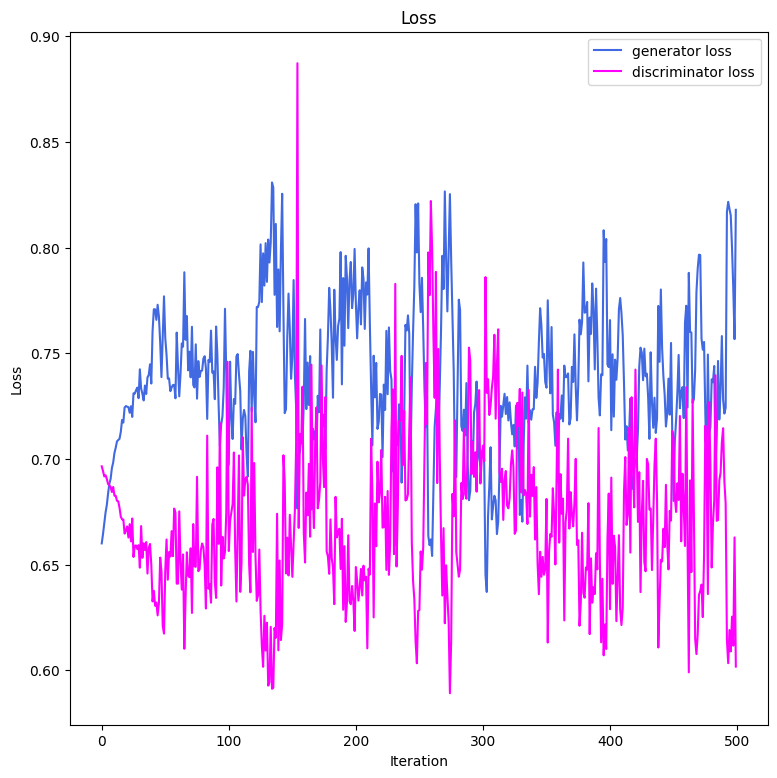

Fit in 427.73 sec


In [30]:
# batch_size is defaut 1 and depending on count
n_epochs = 500

generator_loss_values = []
discriminator_loss_values = []

# real_data = torch.tensor(images, dtype=torch.float).reshape(batch_size, -1)
# normalized_data = (real_data + 1) / 2
# sum_data = normalized_data.sum(dim=1, keepdim=True)
# sum_data[sum_data == 0] = 1.0
# normalized_data = normalized_data / sum_data

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float)

count = 0

start = time.time()
while True:
    for idx, (real_data, _) in enumerate(train_loader):
        count += 1
        real_data = real_data.clone().detach().requires_grad_(True).reshape(batch_size, -1)
        normalized_data = (real_data + 1) / 2
        sum_data = normalized_data.sum(dim=1, keepdim=True)
        sum_data[sum_data == 0] = 1.0
        normalized_data = normalized_data / sum_data

        noise = torch.rand(batch_size, num_qubits) * math.pi / 2
        fake_data = generator(noise)

        discriminator.zero_grad()
        discriminator_real = discriminator(normalized_data).view(-1)
        discriminator_fake = discriminator(fake_data.detach()).view(-1)

        real_loss = loss(discriminator_real, real_labels)
        fake_loss = loss(discriminator_fake, fake_labels)

        real_loss.backward()
        fake_loss.backward()

        discriminator_loss = (real_loss + fake_loss) / 2
        discriminator_optimizer.step()
        discriminator_loss_values.append(discriminator_loss.detach())

        generator.zero_grad()
        discriminator_fake = discriminator(fake_data).view(-1)
        generator_loss = loss(discriminator_fake, real_labels)
        generator_loss.backward()
        generator_optimizer.step()
        generator_loss_values.append(generator_loss.detach())

        plot_training_progress()

        if count == n_epochs:
            break
    if count == n_epochs:
        break


elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")

image is tensor([[[ 0.0000e+00, -6.7070e-09,  0.0000e+00, -6.7070e-09,  5.5479e-04,
           5.4719e-03,  1.9163e-03,  0.0000e+00],
         [-6.7070e-09, -1.3414e-08,  1.2126e-05,  6.4414e-03,  3.6618e-02,
           6.0936e-02,  3.5719e-02,  3.8954e-04],
         [ 0.0000e+00,  3.1419e-05,  9.1277e-03,  5.3796e-02,  4.0036e-02,
           1.6049e-02,  4.7768e-02,  3.2766e-03],
         [-6.7070e-09,  6.6480e-03,  5.9571e-02,  3.8803e-02,  1.6920e-03,
           6.7018e-03,  4.8347e-02,  3.8684e-03],
         [ 0.0000e+00,  2.3911e-02,  5.7829e-02,  3.6467e-03,  1.1347e-03,
           3.3145e-02,  3.4649e-02,  5.1395e-04],
         [-6.7070e-09,  2.6905e-02,  5.9694e-02,  1.0592e-02,  3.3697e-02,
           4.4925e-02,  5.2420e-03, -6.7070e-09],
         [ 0.0000e+00,  6.3857e-03,  5.2645e-02,  6.0648e-02,  4.4490e-02,
           6.4317e-03,  1.3417e-05,  0.0000e+00],
         [ 0.0000e+00,  1.1928e-05,  2.3988e-03,  5.8840e-03,  1.4338e-03,
          -6.7070e-09,  0.0000e+00,  0.00

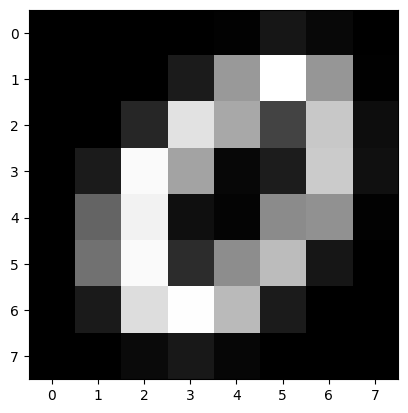

In [31]:
normalized_data = normalized_data.reshape(batch_size, 1, size, size)
img_to_show = normalized_data[0]
plt.imshow(img_to_show.squeeze().detach().numpy(), cmap="gray")
print(f"image is {img_to_show}")

image is tensor([[[0.0000, 0.0000, 0.0000, 0.0010, 0.0068, 0.0020, 0.0000, 0.0000],
         [0.0010, 0.0010, 0.0020, 0.0000, 0.0166, 0.0303, 0.0137, 0.0000],
         [0.0029, 0.0000, 0.0010, 0.0195, 0.0068, 0.0244, 0.0068, 0.0020],
         [0.0039, 0.0000, 0.0059, 0.0420, 0.0762, 0.0205, 0.0000, 0.0029],
         [0.0039, 0.0273, 0.0215, 0.0371, 0.0146, 0.0547, 0.0215, 0.0000],
         [0.0127, 0.0029, 0.0459, 0.0674, 0.1064, 0.1387, 0.0635, 0.0010],
         [0.0010, 0.0029, 0.0215, 0.0029, 0.0273, 0.0088, 0.0000, 0.0000],
         [0.0000, 0.0020, 0.0029, 0.0107, 0.0088, 0.0010, 0.0010, 0.0010]]],
       requires_grad=True)


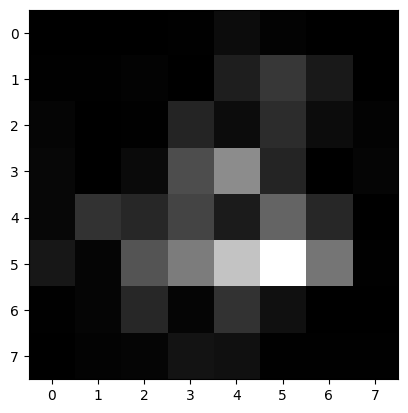

In [32]:
with torch.no_grad():
    generated_data = fake_data.reshape(batch_size, 1, size, size)
    img_to_show = generated_data[0]

    plt.imshow(img_to_show.squeeze().numpy(), cmap="gray")
    print(f"image is {img_to_show}")
